In [3]:
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

# Dataset

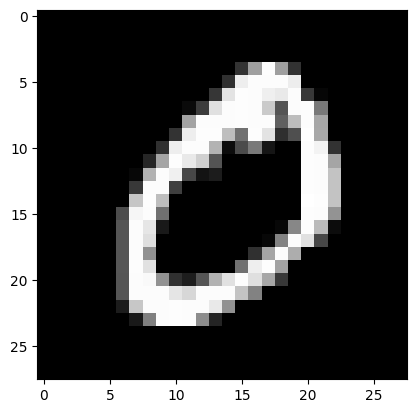

In [2]:
root = './MNIST/'
dataset = torchvision.datasets.MNIST(root = root, train = True, transform = transforms.ToTensor())
x= dataset.__getitem__(1)
plt.imshow(x[0].squeeze(), cmap='gray');

In [10]:
from torch.utils.data import random_split
batch_size=10
train_size=0.9*len(dataset)
val_size=0.1*len(dataset)
train_dataset, val_dataset = random_split(dataset, [int(train_size),int(val_size) ])

# batching
subset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
validation_iter = iter(val_loader)


# Layers

In [4]:
class linear:
    def __init__(self, fan_in, fan_out,generator, bias=True, name='linear', ):
        self.name=name
        # self.w = torch.randn(fan_in, fan_out)
        # self.w = torch.randn(fan_in, fan_out)/fan_in**0.5 #from normal distribution
        # self.w = torch.rand(fan_in, fan_out, generator=generator)/fan_in**0.5  #from uniform distribution -> pytorch uses uniform i believe
        self.w = ((2*(torch.rand(fan_in, fan_out, generator=generator)) )-1) /fan_in**0.5 #-> sampled between -1 and 1
        self.bias = torch.randn(fan_out,generator=generator) if bias else None
    def __call__(self, x):
        # print(x.shape)
        self.out = x @ self.w
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def backwards(self):
        return 'we are here'
    

    def parameters(self):
        return [self.w] + ([] if self.bias is None else [self.bias])
class relu:
    def __init__(self, name='relu'):
        self.name=name
        self.out = None
    def __call__(self,x):
        # self.out =torch.where(x>0, x, 0.0)
        self.out= torch.maximum(x, torch.zeros_like(x))
        return self.out
    def parameters(self):
        return []
class tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
class flatten:   
    def __call__(self, x):
        self.out = x.view(x.size(0), -1) #keep the batch dimension
        # self.out=torch.flatten(x)
        return self.out
    def parameters(self):
        return []
class softmax:
    def __init__(self, beta=1.0):
        self.beta=beta
    def __call__(self, x):
        max = torch.max(x)
        x=x-max
        self.out = torch.exp(x)/torch.sum(torch.exp(x))
        return self.out
    def parameters(self):
        return []

# Model

In [5]:
input_size=784
inner_size=128
output_size=64
cat_size=10
generator=torch.Generator().manual_seed(23)
layers = [
    flatten(),
    linear(input_size,inner_size, name='linear_1',generator=generator),
    tanh(),
    linear(inner_size, cat_size,name='linear_3',generator=generator)
]
parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

In [7]:
def forward(layers, x): 
    # print(x.shape)
    for layer in layers:
        x=layer(x)
        # print(layer.__class__)

        # print(x.shape)
    return x

# Train

In [12]:
lr = 0.01

steps=40000

loss_steps=500

loss_val_batches = 5

i=0

for batch_x, batch_y in subset_loader:

    # print (type(batch_x))
    # print (type(batch_y))

    len_dataset=len(train_dataset)
    index = torch.randint(low=1, high=len_dataset, size=(), generator=generator)

    row=train_dataset.__getitem__(index)
    # out=forward(layers,row[0])
    out=forward(layers,batch_x.squeeze())

    # loss = F.cross_entropy(out.squeeze(),torch.tensor(row[1]))
    loss = F.cross_entropy(out.squeeze(),batch_y)
    
    for layer in layers:
        if not isinstance(layer, flatten):
            layer.out.retain_grad() 
            
    for p in parameters:
        p.grad = None
    loss.backward()
       
    #update parameters
    for p in parameters:
        p.data += -lr*p.grad
        
             
    if i % loss_steps == 0:
        with torch.no_grad():
            losses=torch.zeros(loss_steps)
            for j in range(loss_val_batches):
                val_batch=next(validation_iter)
                val_samples=val_batch[0]
                val_truth=val_batch[1]
                # print(sample.shape)
                out_loss = out=forward(layers, val_samples)
                losses[j] = F.cross_entropy(out_loss,val_truth)
            print(f'step = {i}, val loss over {loss_val_batches} batches = {losses.mean()}')


    i+=1
    # break

step = 0, val loss over 5 batches = 0.03017839789390564
step = 500, val loss over 5 batches = 0.009712292812764645
step = 1000, val loss over 5 batches = 0.008123970590531826
step = 1500, val loss over 5 batches = 0.003947816323488951
step = 2000, val loss over 5 batches = 0.002981896046549082
step = 2500, val loss over 5 batches = 0.004127296153455973
step = 3000, val loss over 5 batches = 0.0034784036688506603
step = 3500, val loss over 5 batches = 0.004050312098115683
step = 4000, val loss over 5 batches = 0.004507785197347403
step = 4500, val loss over 5 batches = 0.004029728937894106
step = 5000, val loss over 5 batches = 0.001986735500395298
